# Lec 16-19: Persistent Programming

Jianwen Zhu <jzhu@eecg.toronto.edu>
v2.0, 2024-09

## Agenda

* File (w/t Exception construct) & Serialization
* Key-Value Store
* Relational Database


## Overview

* So far we have seen

 - Imperative programming constructs
 - Array programming constructs
 - All operating on in-memory data structures / values

* What if power is lost?
  - Data lost (Data Durability)
  - Worse: Not able to restart (Data Consistency) 
  - Latency: Might be OK for stateless, computational programs, but then long latency to start all over again
    
* Service programs
  - Run for a long time (all the time)
  - Keep at least some data in perment storage (disk, flash etc)
  - Examples: OS, web servers

* Large compute programs
  - Out-Of-Core Data Structures
  - = data structures with larger size than RAM
  - long computation: need to check point periodically

## File

* Argubaly best thing ever invented in computer science
* Unix: Everything is a file: expose common, simple interface
* But we will just look the most mundane usage of file here

### Opening file

In [ ]:
fout = open( 'output.txt', 'w' )

### Writing a file

In [ ]:
line1 = "This her's the wattle,\n"
print( fout.write( line1 ) )
len(line1)

In [ ]:
!cat output.txt

### Close a file

In [ ]:
fout.close()
!cat output.txt

### Formating

 - argment of write has to be a string
 - format operator %
 - similar to printf in C, except in expression form

In [ ]:
camels = 42
'%d' % camels

In [ ]:
'I have spotted %d camels.' % camels

If more than one argument, has to use a tuple

In [ ]:
'In %d years I have spotted %d %s.' % (3, 0.1, 'camels')

### Walking Directory Tree

In [ ]:
!touch memo.txt

File never lives in a vacumm, they instead lives in a file system, with a hierarchy of directories. We are using the os package to access (potentially multiple) file systems mounted.

In [ ]:
import os
cwd = os.getcwd()
print( cwd )

In [ ]:
os.path.abspath( 'memo.txt' )

In [ ]:
os.path.exists( 'memo.txt' )

In [ ]:
os.path.isdir( 'memo.txt' )

In [ ]:
os.path.isfile( 'memo.txt' )

In [ ]:
 os.listdir()

In [ ]:
def walk(dir) :
    for name in os.listdir(dir) :
        path = os.path.join( dir, name )
        if os.path.isfile(path) :
           print( path )
        else :
           walk(path)
walk( '.' )

### Exception Handling

Program does not always run as expected. It is sometimes unavoidable as the running environment is not under running program's control. Using return values to signal exceptional conditions are cumbersome as the exception conditions have to "pass up" the calling chain. The exception handling "construct" is invented (almost in every modern language) to make this pattern easier to express. 
It effectively "unwinds" the calling stack from the point where exception is "triggered" to the point when the exception is "handled". 

In python, the syntax for exception handling looks like this.

~~~
try :
    # protected code that might trigger an exception
except :
    # handle exception properly
else :
    # executed only when no exceptions (and unprotected code here)
finally :
    # always run this block with or without exception
~~~

Going back to file handling. 

In [ ]:
fin = open( 'bad_file' )

In [ ]:
fin = open( '/etc/passwd', 'w' )

In [ ]:
fin = open( '/home' )

In [ ]:
try :
    fin = open( 'bad_file' )
    for line in fin :
      print( line )
    fin.close()
except :
    print( 'Something went wrong' )

You can also specify the specific exception (distinguished by a type) to handle.

In [ ]:
try :
    fin = open( 'bad_file' )
except IOError as e:
    print( 'Something went wrong', e )

The IOError is predefined Exception class. 

You can manufacture your Own exception type (using a class, a subject we will touch later, but accept it as is for now). Note that we use the "raise" clause to "throw" an exception.

~~~
class UserNotFoundError(Exception):
    pass
def fetch_user(user_id):
    # Here you would fetch from some kind of db, e.g.:
    # user = db.get_user(user_id)
    # To make this example runnable, let's set it to None
    user = None
    if user == None:
        raise UserNotFoundError(f'User {user_id} not in database')
    else:
        return user
users = [123, 456, 789]
for user_id in users:
    try:
        fetch_user(user_id)
    except UserNotFoundError as e:
        print("There was an error: ", e)
~~~

### Serialization

On-file data format and in-memory format are often different. 
The procedure to convert from in-memory format to on-file format is called
"serialize" or "pickle" or "marshal"; the opposite is called "deserialize" or "unpickling" or "unmarshal". This is often used before writing data to file; or loading data from file.

In [ ]:
import pickle
t = [1, 2, 3]
pickle.dumps( t )

Not really human readible. but we can convert it back:

In [ ]:
t = [1, 2, 3]
s = pickle.dumps( t )
t2 = pickle.loads(s)
print( t2 )

With a string, you can readily read / write data files. 

We can use the pickling package in Python. Industry also come up different packages tied to certain formating (wiring) standards. Today, the popular formats include *protobuf*, which arises from building remote procedure calls (RPCs), or JSON (Javascript Object Notation), which arises from data exchange using HTTP protocol. JSON, specified by RFC 7159 (which obsoletes RFC 4627) and by ECMA-404, is a lightweight data interchange format inspired by JavaScript object literal syntax (although it is not a strict subset of JavaScript). The majority of web services today speaks JSON, and it pays to get familiar with its syntax.

In [ ]:
import json
json.dumps(['foo', {'bar': ('baz', None, 1.0, 2)}])
print(json.dumps("\"foo\bar"))
print(json.dumps('\u1234'))
print(json.dumps('\\'))
print(json.dumps({"c": 0, "b": 0, "a": 0}, sort_keys=True))

In [ ]:
json.dumps([1, 2, 3, {'4': 5, '6': 7}], separators=(',', ':')) # compact encoding

In [ ]:
print(json.dumps({'6': 7, '4': 5}, sort_keys=True, indent=4))  # pretty print

In [ ]:
json.loads('["foo", {"bar":["baz", null, 1.0, 2]}]')  #loading it back

## Key-Value Store

You can of course use the "raw" file interface to accomplish the purpose of persisting your in-memory data. But this would be too cumbersome to use directly in applications. Wouldn't it be nice if we can have a general-purpose data structure where the persistency problem is taken care of and we can reuse-it again and again? Apparently, it pays that the abstraction of this data structure needs to simple, yet versitile enough to be usable in lots of applications.   

### Key-Value Store Abstraction

* Dictionary Abstraction
  - Just like Hash Table
  - Optimized for lookup and update
  - Plus: persistency
    
* Index Abstraction
  - Optimized not only for lookup and update
  - Optimized also for range-search: given a range of keys, enumerate all corresponding values
  - Plus: persistency

### Key-Value Store Deployment Styles

* Embedded
  - Running inside a single computer
  - Offered as a library where application linked directly against
  - Deployed together with application

* Client-Server
  - KV-Store running as a server (a service running on a physical server)
  - Client access service through network
  - Server deployed seperately from application
  - There can be many clients access server simultaneously
  - Client access service either throw a command line interface (CLI) or a client library through a software development kit (SDK), typically in many different languages

* Clustered
  - Like a client-server architecture except you have a group of servers instead of one
  - Data is spread accross different servers to:
    - Load balance requests to increase throughput
    - Increase the capacity of KV-Store with resource of many machines
    - Maintains the abstraction as if it is a single machine

### Example of an Embedded KV Store

In [ ]:
import dbm

db = dbm.open( 'captions', 'c' )
db['cleese.png'] = 'Photo of John Cleese'
print( db['cleese.png'] )
db['cleese.png'] = 'Photo of John Cleese doing a silly walk.'
print( db['cleese.png'] )
db.close()

In [ ]:
!ls

In [ ]:
db = dbm.open( 'captions', 'r' )
print( db['cleese.png'] )
db.close()

Compare the code snippets against the file example, they are very similar in the sense that

* All information is persisted in a file
* All information persisted on file can be loaded back!

However, the KV can be accessed and used like a regular dictionary (that how abstraction works) but we don't have to worry about serialization at all! 

### Redis: (Argubaly) The Most Popular Client-Server KV-Store

 * Problems
 
   - What if I need many applications simultaneously
     accessing the same database?
   
     Example: Horizontally scaled web farm with many different web
     servers running on separate machines, your web app can all call
     on and reference the same database instances

   - String as the only data type supported is two restrictive,
     need *native* data type support

   - Atomicity
   
 * Solution
 
   - Client-Server architecture: database server
   - Redis

 * Now let's go to Actions.

   - Follow the steps installing server on your environment
~~~
%sudo apt install redis
~~~
   - Both server & client artifacts should now be available
   - Lanch service

~~~
%sudo systemctl enable redis-server --now
%systemctl status redis-server
~~~

   - Sanity check:

In [ ]:
!redis-cli --version

In [ ]:
!redis-cli ping

#### String Values

In [ ]:
%pip install redis
import redis
r = redis.Redis("localhost")
r.set("name", "DeGizmo")
r.get("name")

#### Integer Values

In [ ]:
r.set("hit_counter", 1)

In [ ]:
r.incr("hit_counter")

In [ ]:
r.get("hit_counter")

In [ ]:
r.decr("hit_counter")

Now why do we need the API for incr and decr? Isn't it true we can simply using the get/set API and accomplish the same thing? Isn't true a minimal API is what we should advocate? 

What happens if you change "hit_counter" into "bank_balance"? 

#### List Values

Very similar to the built in Python list type, the redis list type has
a few basic methods that combined can quite powerful. We are only
covering a tiny portion of the commands available, you can find all
the commands in the redis Command Reference.


In [ ]:
r.delete("members")
r.rpush("members", "Adam")
r.rpush("members", "Bob")
r.rpush("members", "Carol")

In [ ]:
r.lrange("members", 0, -1)

In [ ]:
r.llen( "members" )

In [ ]:
r.lindex( "members", 1 )

Look what has happened: 

   1. With the r object again we call the method 'rpush' which
      will add the value 'Adam' to the newly created list 'members'
      
   2. We add 'Bob' to the same list
   
   3. Finally we'll add 'Carol'
   
   4. With the lrange method we are asking redis to return all the
      objects in 'members'. lrange takes 3 arguments: key, start index
      in list, end index in list. We are getting the objects from the
      key 'members' starting at index 0 and ending at -1 (which is
      technically the -1, or last index in the list, which will return
      everything)
   
   5. The llen method asks redis to return the length of the list at
      the key 'members' which now has 3 objects
   
   6. lindex method tells redis that we want the object from the key
      'members' at the index position of 1 (remember lists start at
      index 0), so redis returns 'Bob'

We've got some elements in the list at the key 'members'; now lets get
remove some elements.

In [ ]:
r.rpop("members")

In [ ]:
r.lrange("members", 0, -1)

In [ ]:
r.lpop("members")

In [ ]:
 r.lrange("members", 0, -1)

This is what has just happend: 

   1. With the method rpop (right pop) we remove the element in the
      list on the right side (tail), which is 'Carol'
   
   2. Now when we ask for the list 'members' from redis again (from
      the start of 0, and the end of -1 which returns everything) we
      see our list now doesn't have 'Carol'
   
   3. We now lpop (left pop) an element from the list 'members'. This
      will remove the far left element from the list, 'Adam'
   
   4. Now the entire list only contains 'Bob'


#### Set Values

Again, sets perform identically to the built in Python set
type. Simply, sets are lists but, can only have unique values. In the
above example if we added the value Adam (r.lpush('members',
'Adam') ) 20 times our list would contain 20 values all containing the
value 'Adam'. In a set, all elements are unique.

In [ ]:
r.delete("members")

r.sadd("members", "Adam")
r.sadd("members", "Bob")
r.sadd("members", "Carol")
r.sadd("members", "Adam")

In [ ]:
 r.smembers("members")

This is what happened above: 

   1. First off we delete the old list in the key 'members' so we can
      use it as a set
   
   2. Then we sadd (set add) the value 'Adam' to the key 'members'
   
   3. Do the same for the value 'Bob'
   
   4. Do the same for the value 'Carol'
   
   5. Now we try to add the value 'Adam' to the key 'members' again
      but, this time it returns 'False' since we are working on a set,
      and a set only has unique values. There already is a value
      'Adam' present in this set
   
   6. The method smembers returns all the members of the set in the
      Python type set

An example of a use of sets in a web application would be for
'upvotes' on a reddit, or hacker news type website. We want to keep
track of who up votes a story but, you should only be able to up vote
a story once.


In [ ]:
r.sadd("story:5419:upvotes", "userid:9102")
r.sadd("story:5419:upvotes", "userid:12981")
r.sadd("story:5419:upvotes", "userid:1233")
r.sadd("story:5419:upvotes", "userid:9102")
r.scard("story:5419:upvotes")

In [ ]:
r.smembers("story:5419:upvotes")

I added a little twist in here with the name of the key:
'story:5419:upvotes' but, it's easy to explain. Redis is 'flat' with
it's keyspace. So if we have many different stories we use a fixed key
naming convention for easy reference in redis. For this example our
key is broken down like this: 'object type' : 'id' : 'attribute'. So,
we have an object of type 'story' with an ID of '5419' with an
attribute 'upvotes'. Redis has no idea what any of this means it just
knows the key is 'story:5419:upvotes' but, it doesn't matter, we know
what it means and we can divide up our objects into this name space to
make it easier to work with and keep from 'losing' things. The value
being added to the key is divided up in the same way. 'userid' is the
type and '9102' is the value or the ID for that user voting on the
story.

   1. Just like before we are adding the value 'userid:9102' to the
      key 'story:5419:upvotes'
   
   2. Now we are adding the value 'userid:12981'
   
   3. Finally adding the valud 'userid:1233'
   
   4. Now, the user with the ID 9102 tries to up vote the story with
      the ID 5419 again, and redis returns False since that user has
      already up votes this story before and you can't up vote a story
      twice!
   
   5. The method 'scard' is asking redis for the cardinality of the
set at key 'story:5419:upvotes' or how many things are in this set,
and redis returns 3.  6. Finally we return the list of userid's that
we have stored in the set.

#### Ordered Set Value

The last data structure we are going to talk about today is an ordered
(or sorted) set. This operates just like a set but, has an extra
attribute when we add something to a set called a 'score'. This score
determines the order of the elements in the set. We will stick with
the concept for this example.

In [ ]:
r.zadd("stories:frontpage", {"storyid:3123":34} )
r.zadd("stories:frontpage", {"storyid:9001":3} )
r.zadd("stories:frontpage", {"storyid:2134":127} )
r.zadd("stories:frontpage", {"storyid:2134":127} )
r.zrange("stories:frontpage", 0, -1, withscores=True)

In [ ]:
frontpage = r.zrange("stories:frontpage", 0, -1, withscores=True)
frontpage.reverse()
frontpage

Quick namespace explanation like before. For the key we are going to
be referring to 'stories:frontpage' which is going to be a set of
stories slated for the front page of our website. We are storing in
that key the value of 'storyid:3123' which is the ID of some story on
the site and then a score, which in our case is going to be the number
of votes on a story.

   1. First we add the value 'storyid:3123' to 'stories:frontpage',
      and 'storyid:3123' in our example is going to have 34 votes.
   
   2. Then add 'storyid:9001' with 3 votes
   
   3. Then add 'storyid:2134' with 127 votes
   
   4. We are going to try to add 'story:2134' to the set again but, we
      can't since it already exists.
   
   5. Now we are going to ask redis for all the elements in
      'stories:frontpage' from index 0 to index -1 (the end of the
      list) with all associated scores (withscores=True)
   
   6. We've got the scores but, they are in ascending order, we want
      them in descending order for our website, so we are going to
      store the results in the variable 'frontpage'
   
   7. Then reverse it (which is an in place operation in Python)
   
   8. Now print out the front page!


In conclusion let's do a quick example of a 'view' in an application
in which a user will vote of a story  using redis as a storage engine

~~~
#given variables
#r   = our redis server
#user_id    = the user who voted on the story
#story_id   = the story which the user voted on
if r.sadd("story:%s" % story_id, "userid:%s" % user_id):
    r.zincrby("stories:frontpage", "storyid:%s" % story_id, 1)
~~~

2 lines of code' This is might compact but, once we unravel it we can
see how it makes sense and how powerful redis can be. Let's start with
the if statement.

~~~
	if r.sadd("story:%s" % story_id, "userid:%s" % user_id):
~~~

We know the command 'sadd' already. This will add an element to a set
at a key. The key in this case is

~~~
	"story:%s" % story_id
~~~

If story_id is 3211, then the resulting string will be
'story:3211'. This is the key in redis which contains the list of
users that has voted on the story.

The value to be inserted at this key is

~~~
	"userid:%s" % user_id
~~~

Just like with story, if the user_id is 9481 then the string to be
inserted into the set at 'story:3211' will be 'user_id:9481'

Now the redis command 'sadd' will return False if that element is
already present in the set. So if a user has already voted on this
story before we don't execute the statement under the if. But, if it
is added, then we have a brand new vote and we have to increment the
votes for the front page.

~~~
	r.zincrby("stories:frontpage", "storyid:%s" % story_id, 1)
~~~

We have an ordered set at the key 'stories:frontpage' and we are going
to increment the element 'storyid:%s' % story_id ('story:3211') by 1.

And now we're done! We've made sure the user hasn't voted on this
story before and then we've incremented the number of votes for this
story on the front page!


In [ ]:
def vote( user_id, story_id ) :
    if r.sadd( "story:%s" % story_id, "userid:%s" % user_id) :
        r.zincrby( "stories:frontpage", "storyid:%s" % story_id, 1 )

That's it! You have the material to build something really powerful!

## Relation Database

We can also use the venerable relational database, which builds on the abstraction of a "table" (or called relation mathematically). A table is a set of rows with identical structure: a set of colume values of pre-defined data types. The pre-defined structure is called a "schema". A table is really not much different from an Excel table. 

The reason why people love to use relational database is two-folds: 

1. It is rigourously design with nice ACID (Atomic, Consistency, Isolation, Durable) properties;
2. It is equipped with a power SQL language for query and other operations.

If you can cast your data structures in relational database abstraction, you usually have a good starting point.

### Manipulating Embedded Database

In [2]:
%pip install pysqlite3

Note: you may need to restart the kernel to use updated packages.


In [4]:
from sqlite3 import *
conn = connect('sample.db')
curs = conn.cursor()

This creates an empty SQLite database in the current directory, or
connects to one previously created. The cursor - curs-, is simply the
object instance which directs your query-like methods to the
particular database.

Now let us create a table called "items":

In [5]:
curs.execute('''create table items
  (id integer primary key, itemno text unique,
        scancode text, descr text, price real)''')

This statement causes a table to be created with a primary key, a
unique item no., and three more fields. If you were to interact
directly with SQLite from the command line, it would look something
like this:

~~~
$ sqlite3 sample.db
SQLite version 3.3.13
Enter ".help" for instructions
sqlite>  create table item (id integer primary key, itemno text unique,
   ...>         scancode text, descr text, price real);
~~~

Now let us add some data to the item table:

In [8]:
curs.execute("insert into items values\
            (NULL,0001,32187645,'Milk',2.50)")
curs.execute("insert into items values\
            (NULL,0002,45321876,'Beer',4.50)")
curs.execute("insert into items values\
            (NULL,0003,18764532,'Bread',1.50)")
conn.commit()

As you can see, our sample Python code passes a "create table" statement, via the execute() method. The argument to the execute method is the string that we would key in interactive mode, without the semicolon.

Notice that I gave the value NULL to the primary key. This will cause the next integer value to be assigned to the key. And the commit() method will force the changes to be updated. It would not be terribly inefficient to commit every time you make a change to the database, this guarantee that the data inserted before commit is *durable*.

In [6]:
!ls -l

total 2344
-rw------- 1 jzhu jzhu 1057164 Oct  1 11:08 Google.pdf
-rw-r--r-- 1 jzhu jzhu  308767 Oct 11 13:25 IMDB-Movie-Data.csv
-rw------- 1 jzhu jzhu   16143 Sep 25 15:51 Prefix_sum_16.svg.png
-rw-r--r-- 1 jzhu jzhu   12288 Oct  9 16:23 captions.db
-rw-r--r-- 1 jzhu jzhu    6671 Sep 15 06:53 lec1.ipynb
-rw-r--r-- 1 jzhu jzhu  664868 Oct 10 14:56 lec10-12.ipynb
-rw-r--r-- 1 jzhu jzhu   18810 Oct  8 15:36 lec13-15.ipynb
-rw-r--r-- 1 jzhu jzhu   52767 Oct 11 16:21 lec16-19.ipynb
-rw-r--r-- 1 jzhu jzhu   29784 Sep 15 06:47 lec2-3.ipynb
-rw-r--r-- 1 jzhu jzhu   42311 Sep 25 14:59 lec4-6.ipynb
-rw-r--r-- 1 jzhu jzhu  153442 Sep 25 14:59 lec7-9.ipynb
-rw-r--r-- 1 jzhu jzhu       0 Oct  8 16:27 memo.txt
-rw-r--r-- 1 jzhu jzhu      69 Oct  8 16:22 output.txt
-rw-r--r-- 1 jzhu jzhu   12288 Oct 11 16:19 sample.db


If we interact with SQLite with command line tool, we would have the following:

~~~
sqlite> select * from item;
1|1|32187645|Milk|2.5
2|2|45321876|Beer|4.5
3|3|18764532|Bread|1.5
~~~

Now let's use Python to interact programmably.

In [9]:
curs.execute("select * from items")
for row in curs:
    print( row )

(1, '1', '32187645', 'Milk', 2.5)
(2, '2', '45321876', 'Beer', 4.5)
(3, '3', '18764532', 'Bread', 1.5)


As you can see, the select causes curs to look like a list of rows of columns. The rows are tuples.

Now let us create an item-vendor table and populate it.

In [10]:
curs.execute('''create table itemvendor
  (id integer primary key, itemno text, vendor text)''')
curs.execute("insert into itemvendor values\
            (NULL,0001,2345)")
curs.execute("insert into itemvendor values\
            (NULL,0002,6789)")
curs.execute("insert into itemvendor values\
            (NULL,0001,0543)")
conn.commit()

Now, just for fun, let us do a simple join, and see the results:

In [11]:
curs.execute("select * from items LEFT OUTER JOIN itemvendor ON items.itemno = itemvendor.itemno")
for row in curs:
    print( row )

(1, '1', '32187645', 'Milk', 2.5, 1, '1', '2345')
(1, '1', '32187645', 'Milk', 2.5, 3, '1', '543')
(2, '2', '45321876', 'Beer', 4.5, 2, '2', '6789')
(3, '3', '18764532', 'Bread', 1.5, None, None, None)


### Manipulating In-Memory Data Frames
Relational databases obviously help to persist your entire dataset. Most of the times, you only need a small subset of it at a time, and you can certainly get that subset using SQL query. But typically, we will need to further process the query reset for various purposes. We will now introduce another handy tool for this purpose. The tool is called Pandas, and has become the de facto standard for data science.

Pandas builds on the concept of:

* "DataFrame", which you can conceptually think of it as a table in memory;
* "Series", which you can conceptually think of it as a column of a table; 

In addition to thinking of a table as a collection of rows, you can obviously also think of a table as a collection of columns, aligned together by a "primary key". 

Now let's get into action. 

In [12]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd

df = pd.read_sql_query( "SELECT * FROM items" , conn)
df

,id,itemno,scancode,descr,price
0,1,1,32187645,Milk,2.5
1,2,2,45321876,Beer,4.5
2,3,3,18764532,Bread,1.5


What has just happened? It is no different conceptually from the SQL query we have done before. Except that now the result is held in a DataFrame in memory implemented by the pandas package. It apparently has a better integration with Jupyter so in this environment it renders much nicely. But we can do more.

First thing is we can have a variety of *data sources* in addition to relational databases.

* Creating Data Frames from Other Sources

In [14]:
data = {
    'apples': [3, 2, 0, 1], 
    'oranges': [0, 3, 7, 2]
}
purchases = pd.DataFrame(data)
purchases

,apples,oranges
0,3,0
1,2,3
2,0,7
3,1,2


The Index of this DataFrame was given to us on creation as the numbers 0-3, but we could also create our own when we initialize the DataFrame.

Let's have customer names as our index:

In [15]:
purchases = pd.DataFrame(data, index=['June', 'Robert', 'Lily', 'David'])

purchases

,apples,oranges
June,3,0
Robert,2,3
Lily,0,7
David,1,2


In [16]:
purchases.loc['June']

apples     3
oranges    0
Name: June, dtype: int64

Let's directly persist it into a file. Here we use CSV: comma seperated list. This is the file format Excel can accept.

In [19]:
purchases.to_csv('new_purchases.csv')

In [20]:
!cat new_purchases.csv

,apples,oranges
June,3,0
Robert,2,3
Lily,0,7
David,1,2


In [21]:
purchases.to_json( 'new_purchases.json' )

In [22]:
!cat new_purchases.json

{"apples":{"June":3,"Robert":2,"Lily":0,"David":1},"oranges":{"June":0,"Robert":3,"Lily":7,"David":2}}

In [ ]:
And of course we can load them back.

In [23]:
new_purchases = pd.read_csv( 'new_purchases.csv' )
new_purchases

,Unnamed: 0,apples,oranges
0,June,3,0
1,Robert,2,3
2,Lily,0,7
3,David,1,2


In [24]:
new_purchases = pd.read_json( 'new_purchases.json' )
new_purchases

,apples,oranges
June,3,0
Robert,2,3
Lily,0,7
David,1,2


* Larger Data Set

  Now let's deal with larger dataset.

In [25]:
movies_df = pd.read_csv("IMDB-Movie-Data.csv", index_col="Title")

The first thing to do when opening a new dataset is print out a few rows to keep as a visual reference. We accomplish this with .head():

In [29]:
movies_df.head(2)

,Rank,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
Title,,,,,,,,,,,
Guardians of the Galaxy,1,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0


In [30]:
movies_df.tail(2)

,Rank,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
Title,,,,,,,,,,,
Search Party,999,"Adventure,Comedy",A pair of friends embark on a mission to reuni...,Scot Armstrong,"Adam Pally, T.J. Miller, Thomas Middleditch,Sh...",2014,93,5.6,4881,NaN,22.0
Nine Lives,1000,"Comedy,Family,Fantasy",A stuffy businessman finds himself trapped ins...,Barry Sonnenfeld,"Kevin Spacey, Jennifer Garner, Robbie Amell,Ch...",2016,87,5.3,12435,19.64,11.0


In [31]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, Guardians of the Galaxy to Nine Lives
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Genre               1000 non-null   object 
 2   Description         1000 non-null   object 
 3   Director            1000 non-null   object 
 4   Actors              1000 non-null   object 
 5   Year                1000 non-null   int64  
 6   Runtime (Minutes)   1000 non-null   int64  
 7   Rating              1000 non-null   float64
 8   Votes               1000 non-null   int64  
 9   Revenue (Millions)  872 non-null    float64
 10  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(4)
memory usage: 93.8+ KB


In [32]:
movies_df.columns

Index(['Rank', 'Genre', 'Description', 'Director', 'Actors', 'Year',
       'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)',
       'Metascore'],
      dtype='object')

* Manipulating Data Frames

In [33]:
movies_df.columns = [col.lower() for col in movies_df]
movies_df.columns

Index(['rank', 'genre', 'description', 'director', 'actors', 'year',
       'runtime (minutes)', 'rating', 'votes', 'revenue (millions)',
       'metascore'],
      dtype='object')

We just change the names of all columns into lower case.

Let's drop all rows with null values. We should expect a smaller data set.

In [34]:
movies_df.dropna()

,rank,genre,description,director,actors,year,runtime (minutes),rating,votes,revenue (millions),metascore
Title,,,,,,,,,,,
Guardians of the Galaxy,1,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
Split,3,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
Sing,4,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
Suicide Squad,5,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0
...,...,...,...,...,...,...,...,...,...,...,...
Resident Evil: Afterlife,994,"Action,Adventure,Horror",While still out to destroy the evil Umbrella C...,Paul W.S. Anderson,"Milla Jovovich, Ali Larter, Wentworth Miller,K...",2010,97,5.9,140900,60.13,37.0
Project X,995,Comedy,3 high school seniors throw a birthday party t...,Nima Nourizadeh,"Thomas Mann, Oliver Cooper, Jonathan Daniel Br...",2012,88,6.7,164088,54.72,48.0
Hostel: Part II,997,Horror,Three American college students studying abroa...,Eli Roth,"Lauren German, Heather Matarazzo, Bijou Philli...",2007,94,5.5,73152,17.54,46.0


* Visualization and Plotting

  You could visualize your data pretty much the same way as what Excel can do for you, using matplotlib again.

In [35]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20, 'figure.figsize': (10, 8)}) # set font and plot size to be larger


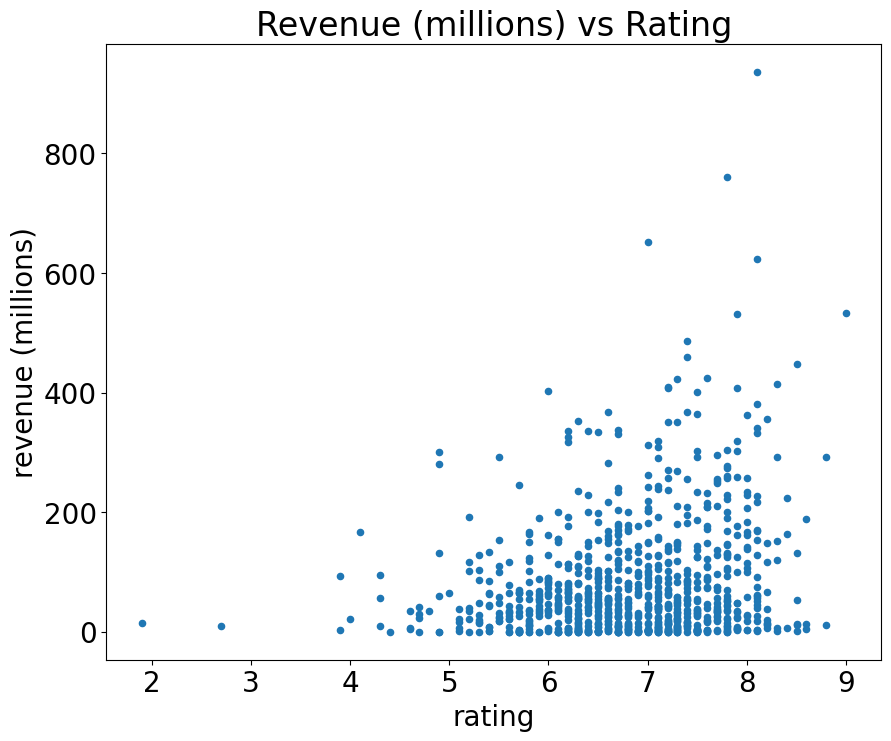

In [36]:
movies_df.plot(kind='scatter', x='rating', y='revenue (millions)', title='Revenue (millions) vs Rating');

## Recap

* Needs for persistent programming 
    - When data size exceeds RAM capacity of your machines
    - When you need to protect your data from power outage
      
* Files: roll your own solution

* Key-Value Stores: 
  - Extension of Dictionary
  - Extension of Ordered index
  - Many existing solutions out there
  
* Relational Database
  - Relation and calculus on them
  - View the world as tables (what isn't?)
  - Very mature: decades of research & commercial support
